In [75]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image
import random


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation, MaxPooling2D, Concatenate, AveragePooling2D

from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination

In [76]:
SEED = 64

# SET RANDOM SEED FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [77]:
# Create variable to store dataset name
dataset_name = 'boston'
results_path = f'logs/{dataset_name}/CNN+MLP_Regression'

In [78]:
df = pd.read_csv(f"../Datasets_benchmark/{dataset_name}.csv")

LOAD AND PREPROCESS

In [79]:
from sklearn.preprocessing import MinMaxScaler
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type):

    # Generate the images if the folder does not exist
    if not os.path.exists(images_folder):
        #Generate thet images
        image_model.generateImages(df, images_folder)
    else:
        print("The images are already generated")

    img_paths = os.path.join(images_folder,problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, df], axis=1)

    # Split data
    df_x = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    df_y = combined_dataset["values"]

    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.40, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)

    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    imgs_shape = X_train_img[0].shape

    print("Images shape: ",imgs_shape)
    print("Attributres: ",attributes)
    pixels=X_train_img[0].shape[0]
    print("Image size (pixels):", pixels)

    return X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes

MODEL ARCHITECTURES

In [80]:
# Small CNN + MLP

def create_model1(cnn_input_shape, mlp_input_shape):

    # MLP branch
    mlp_input = Input(shape=mlp_input_shape)
    mlp_output = Dense(16, activation='relu')(mlp_input)
    mlp_output = Dense(32, activation='relu')(mlp_output)
    mlp_output = Dense(16, activation='relu')(mlp_output)

    # CNN branch
    cnn_input = Input(shape=cnn_input_shape)
    cnn_output = Conv2D(4, (2, 2), activation='relu')(cnn_input)
    cnn_output = Flatten()(cnn_output)

    # Concatenate the outputs of CNN and MLP branches
    concat_output = Concatenate()([cnn_output, mlp_output])

    # Final MLP layers
    final_output = Dense(32, activation='relu')(concat_output)
    final_output = Dense(16, activation='relu')(final_output)
    final_output = Dense(8, activation='relu')(final_output)
    final_output = Dense(1, activation='linear')(final_output)  # Output layer for regression

    # Create and return the model
    model1 = Model(inputs=[mlp_input, cnn_input], outputs=final_output)
    return model1

In [81]:
# Medium CNN + MLP

def create_model2(cnn_input_shape, mlp_input_shape):

    # MLP branch
    mlp_dropout = 0.1
    mlp_input = Input(shape=mlp_input_shape)
    # MLP brach 1
    mlp_1 = Dense(1024, activation='relu')(mlp_input)
    mlp_1 = BatchNormalization()(mlp_1)
    mlp_1 = Dropout(mlp_dropout)(mlp_1)

    mlp_1 = Dense(512, activation='relu')(mlp_1)
    mlp_1 = BatchNormalization()(mlp_1)
    mlp_1 = Dropout(mlp_dropout)(mlp_1)

    mlp_1 = Dense(256, activation='relu')(mlp_1)
    mlp_1 = BatchNormalization()(mlp_1)
    mlp_1 = Dropout(mlp_dropout)(mlp_1)

    mlp_1 = Dense(128, activation='relu')(mlp_1)
    mlp_1 = BatchNormalization()(mlp_1)
    mlp_1 = Dropout(mlp_dropout)(mlp_1)

    mlp_1 = Dense(64, activation='relu')(mlp_1)
    mlp_1 = BatchNormalization()(mlp_1)
    mlp_1 = Dropout(mlp_dropout)(mlp_1)

    mlp_1 = Dense(32, activation='relu')(mlp_1)
    mlp_1 = BatchNormalization()(mlp_1)
    mlp_1 = Dropout(mlp_dropout)(mlp_1)

    mlp_1 = Dense(16, activation='relu')(mlp_1)
    mlp_1 = BatchNormalization()(mlp_1)
    mlp_1 = Dropout(mlp_dropout)(mlp_1)

    # MLP brach 2
    mlp_2 = Dense(1024, activation='relu')(mlp_input)
    mlp_2 = BatchNormalization()(mlp_2)
    mlp_2 = Dropout(mlp_dropout)(mlp_2)

    mlp_2 = Dense(512, activation='relu')(mlp_2)
    mlp_2 = BatchNormalization()(mlp_2)
    mlp_2 = Dropout(mlp_dropout)(mlp_2)

    mlp_2 = Dense(256, activation='relu')(mlp_2)
    mlp_2 = BatchNormalization()(mlp_2)
    mlp_2 = Dropout(mlp_dropout)(mlp_2)

    mlp_2 = Dense(128, activation='relu')(mlp_2)
    mlp_2 = BatchNormalization()(mlp_2)
    mlp_2 = Dropout(mlp_dropout)(mlp_2)

    mlp_2 = Dense(64, activation='relu')(mlp_2)
    mlp_2 = BatchNormalization()(mlp_2)
    mlp_2 = Dropout(mlp_dropout)(mlp_2)

    mlp_2 = Dense(32, activation='relu')(mlp_2)
    mlp_2 = BatchNormalization()(mlp_2)
    mlp_2 = Dropout(mlp_dropout)(mlp_2)

    mlp_2 = Dense(16, activation='relu')(mlp_2)
    mlp_2 = BatchNormalization()(mlp_2)
    mlp_2 = Dropout(mlp_dropout)(mlp_2)

    mlp_output = Concatenate(axis=1)([mlp_1, mlp_2])

    # CNN branch
    cnn_dropout = 0.1
    cnn_input = Input(shape=cnn_input_shape)
    # CNN branch 1
    tower_1 = Conv2D(16, (3,3), activation='relu',padding="same")(cnn_input)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation('relu')(tower_1)
    tower_1 = MaxPooling2D(2,2)(tower_1)
    tower_1 = Dropout(cnn_dropout)(tower_1)

    tower_1 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation('relu')(tower_1)
    tower_1 = MaxPooling2D(2,2)(tower_1)
    tower_1 = Dropout(cnn_dropout)(tower_1)

    tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation('relu')(tower_1)
    tower_1 = MaxPooling2D(2,2)(tower_1)
    tower_1 = Dropout(cnn_dropout)(tower_1)

    tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation('relu')(tower_1)
    tower_1 = MaxPooling2D(2,2)(tower_1)
    tower_1 = Dropout(cnn_dropout)(tower_1)

    # CNN branch 2
    tower_2 = Conv2D(16, (5,5), activation='relu',padding="same")(cnn_input)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation('relu')(tower_2)
    tower_2 = AveragePooling2D(2,2)(tower_2)
    tower_2 = Dropout(cnn_dropout)(tower_2)

    tower_2 = Conv2D(32, (5,5), activation='relu',padding="same")(tower_2)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation('relu')(tower_2)
    tower_2 = AveragePooling2D(2,2)(tower_2)
    tower_2 = Dropout(cnn_dropout)(tower_2)

    tower_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation('relu')(tower_2)
    tower_2 = AveragePooling2D(2,2)(tower_2)
    tower_2 = Dropout(cnn_dropout)(tower_2)

    tower_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation('relu')(tower_2)
    tower_2 = AveragePooling2D(2,2)(tower_2)
    tower_2 = Dropout(cnn_dropout)(tower_2)

    #Concatenate CNN branches
    merged_cnn = Concatenate(axis=1)([tower_1, tower_2])

    #Flatten
    merged = Flatten()(merged_cnn)

    #Dense layers
    out = Dense(256, activation='relu')(merged)
    out = Dropout(cnn_dropout)(merged)
    out = Dense(128, activation='sigmoid')(out)
    out = Dropout(cnn_dropout)(out)
    out = Dense(64, activation='sigmoid')(out)
    out = Dropout(cnn_dropout)(out)
    out = Dense(32, activation='sigmoid')(out)
    cnn_output = Dropout(cnn_dropout)(out)

    # Concatenate the outputs of CNN and MLP branches
    concat_output = Concatenate()([mlp_output, cnn_output])

    # Final MLP layers
    final_output = Dense(48, activation='relu')(concat_output)
    final_output = Dense(1, activation='linear')(final_output)  # Output layer for regression

    # Create and return the model
    model2 = Model(inputs=[mlp_input, cnn_input], outputs=final_output)
    return model2

METRICS

In [82]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

COMPILE AND FIT

In [83]:
from tensorflow.keras.callbacks import EarlyStopping

def compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, model_name, batch_size=32, epochs=200, lr=1e-3):

    opt = Adam(learning_rate=lr)

    # Define the early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement
        patience=20,          # Number of epochs with no improvement after which training will be stopped
        verbose=1,           # Print messages when the callback takes an action
        mode='min',           # Training will stop when the quantity monitored has stopped decreasing
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    
    model.compile(
        loss="mse",
        optimizer=opt,
        metrics=METRICS
    )

    model_history = model.fit(
        x=[X_train_num,X_train_img], y=y_train,
        validation_data=([X_val_num,X_val_img], y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    os.makedirs(f"models/{dataset_name}/{model_name}", exist_ok=True)

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
    plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/loss_plot.png")

    plt.figure()  # Start a new figure
    plt.plot(model_history.history['mse'], color = 'red', label = 'mse')
    plt.plot(model_history.history['val_mse'], color = 'green', label = 'val mse')
    plt.legend(loc = 'upper right')
    plt.savefig(f"models/{dataset_name}/{model_name}/mse_plot.png")

    # Save the model
    os.makedirs(f"models/{dataset_name}/{model_name}", exist_ok=True)
    model.save(f"models/{dataset_name}/{model_name}/model_{dataset_name}.keras")

    # Evaluate the model on the training set
    train_scores = model.evaluate([X_train_num,X_train_img], y_train)

    # Evaluate the model on the validation set
    val_scores = model.evaluate([X_val_num,X_val_img], y_val)

    # Evaluate the model on the test set
    score_test = model.evaluate([X_test_num,X_test_img], y_test)

    # Save training, validation, and test scores
    metrics = {
        'train_loss': train_scores[0],
        'train_mse': train_scores[1],
        'train_mae': train_scores[2],
        'train_rmse': train_scores[3],
        'train_r2': train_scores[4],
        'val_loss': val_scores[0],
        'val_mse': val_scores[1],
        'val_mae': val_scores[2],
        'val_rmse': val_scores[3],
        'val_r2': val_scores[4],
        'test_loss': score_test[0],
        'test_mse': score_test[1],
        'test_mae': score_test[2],
        'test_rmse': score_test[3],
        'test_r2': score_test[4]
    }

    # Save metrics to a file
    os.makedirs(f'{results_path}/{model_name}', exist_ok=True)
    with open(f'{results_path}/{model_name}/{dataset_name}_metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')

    return metrics

In [84]:
def safe_compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test,dataset_name, model_name, batch_size=32, epochs=200, lr=1e-3):
    try:
        metrics = compile_and_fit(model, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test,dataset_name, model_name, batch_size, epochs, lr)
        return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None

0.4807
- Anadir capa final : 0.4225 Mejor
- Anadir capa despues del CNN: 0.4408 No Mejor
- Modelo mas complejo no mejora, podria ser porque este dataset tiene pocas features o puede ser que no tenga mucho spatial relationship y la CNN no sirva para nada.

TEST

In [85]:
#Select the model and the parameters
problem_type = "regression"
#image_model = REFINED(problem= problem_type,hcIterations=5)
image_model = TINTO(problem= problem_type, blur=True)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_IGTD"

In [86]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_TINTO"

In [87]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

The images are already generated
../HyNNImages/Regression/boston/images_boston_TINTO\regression.csv
Images shape:  (20, 20, 3)
Attributres:  13
Image size (pixels): 20


In [88]:
model1 = create_model1(imgs_shape, (attributes,))
model2 = create_model2(imgs_shape, (attributes,))

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 436.2835 - mae: 18.7150 - mse: 436.2835 - r_square: -4.5687 - rmse: 20.8294 - val_loss: 157.2861 - val_mae: 9.4424 - val_mse: 157.2861 - val_r_square: -2.4119 - val_rmse: 12.5414
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 122.0619 - mae: 8.1312 - mse: 122.0619 - r_square: -0.5483 - rmse: 11.0367 - val_loss: 78.9305 - val_mae: 7.1374 - val_mse: 78.9305 - val_r_square: -0.4996 - val_rmse: 8.8843
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75.3288 - mae: 6.5770 - mse: 75.3288 - r_square: 0.0469 - rmse: 8.6738 - val_loss: 60.8386 - val_mae: 5.8503 - val_mse: 60.8386 - val_r_square: -0.5372 - val_rmse: 7.7999
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.2874 - mae: 5.0869 - mse: 50.2874 - r_square: 0.3748 - rmse: 7.0634 - val_loss: 56.4007 - val_mae: 5.7649 - val_mse: 56.4007 - val_r_square: -0.3932 - val_rmse: 7.5100
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.7580 

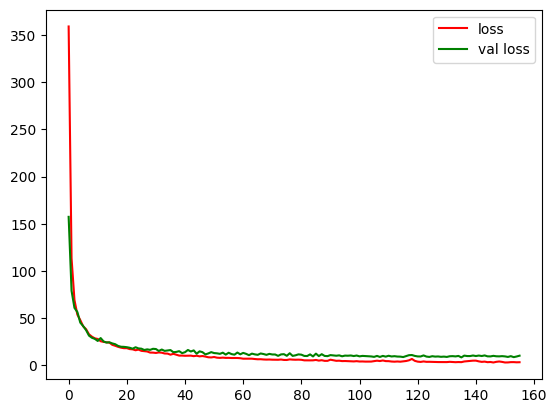

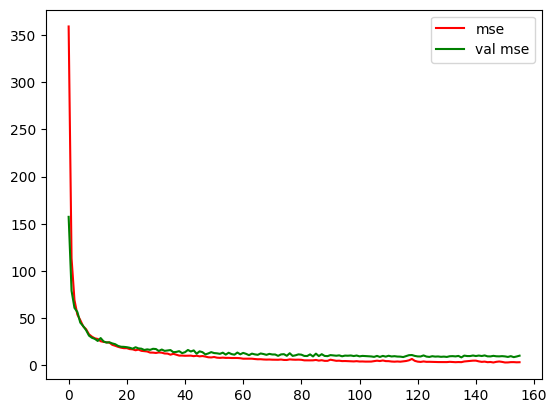

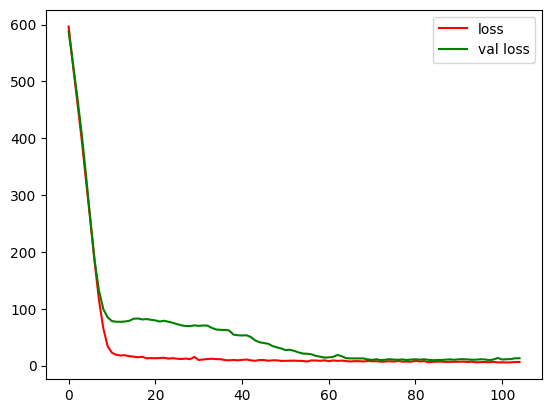

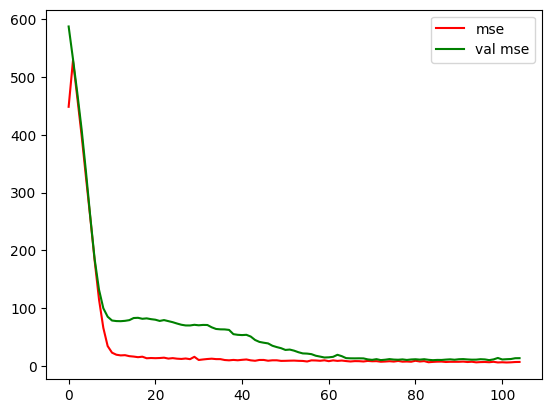

In [89]:
# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, "TINTO_model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, "TINTO_model2")

# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)

In [90]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=4)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_Combination_zoom4"

In [91]:
X_train_num, X_val_num, X_test_num, X_train_img, X_val_img, X_test_img, y_train, y_val, y_test, imgs_shape, attributes = load_and_preprocess_data(images_folder, image_model, problem_type)

The images are already generated
../HyNNImages/Regression/boston/images_boston_Combination_zoom4\regression.csv
Images shape:  (52, 52, 3)
Attributres:  13
Image size (pixels): 52


In [92]:
model1 = create_model1(imgs_shape, (attributes,))
model2 = create_model2(imgs_shape, (attributes,))

Epoch 1/200


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2936.9038 - mae: 27.9796 - mse: 1691.0670 - r_square: -40.5928 - rmse: 40.6373 - val_loss: 145.1314 - val_mae: 9.4356 - val_mse: 145.1314 - val_r_square: -2.3748 - val_rmse: 12.0471
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 270.9459 - mae: 13.4633 - mse: 270.9459 - r_square: -2.3806 - rmse: 16.3598 - val_loss: 131.9485 - val_mae: 9.9406 - val_mse: 131.9485 - val_r_square: -3.2519 - val_rmse: 11.4869
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 122.5518 - mae: 8.7278 - mse: 122.5518 - r_square: -0.4907 - rmse: 11.0574 - val_loss: 104.6617 - val_mae: 8.7216 - val_mse: 104.6617 - val_r_square: -2.2103 - val_rmse: 10.2304
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 81.1793 - mae: 7.1806 - mse: 81.1793 - r_square: -0.0256 - rmse: 9.0034 - val_loss: 73.3690 - val_mae: 6.8966 - val_mse: 73.3690 - val_r_square: -1.1623 - val_rmse: 8.5656
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.76

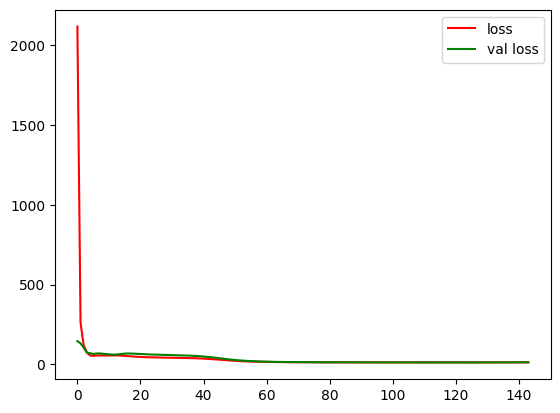

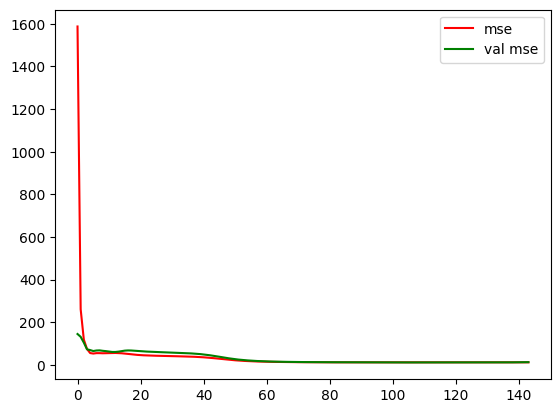

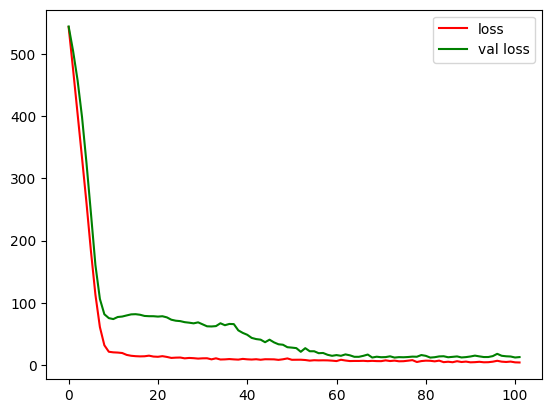

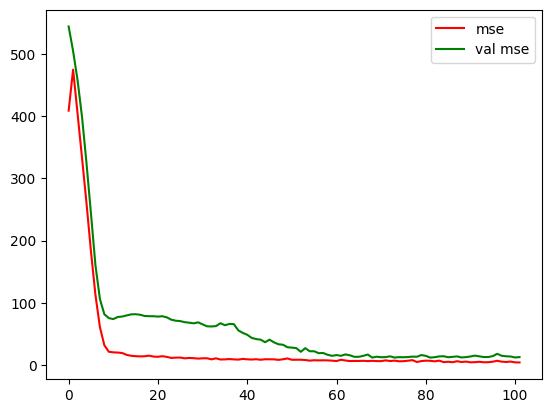

In [93]:
# Example usage with two models
model1_metrics = safe_compile_and_fit(model1, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, "Combination_zoom4_model1")
model2_metrics = safe_compile_and_fit(model2, X_train_num, X_train_img, y_train, X_val_num, X_val_img, y_val, X_test_num, X_test_img, y_test, dataset_name, "Combination_zoom4_model2")


# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)

In [94]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'{dataset_name}_metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [95]:
import os

def rename_folder(old_folder_path):
    # Extract the base name of the old folder
    folder_name = os.path.basename(old_folder_path)
    
    # Create the new folder name by prepending "best_"
    new_folder_name = f"BEST_{folder_name}"
    
    # Get the parent directory of the old folder
    parent_dir = os.path.dirname(old_folder_path)
    
    # Create the full path for the new folder
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    
    # Rename the folder
    os.rename(old_folder_path, new_folder_path)
    
    return new_folder_path

In [96]:
# Usage
base_path = f"logs/{dataset_name}/CNN+MLP_Regression"
best_folder, best_rmse = find_best_model(base_path)
best_folder = rename_folder(best_folder)
print(f"Best model folder: {best_folder}")
print(f"Best RMSE: {best_rmse}")

Best model folder: logs/boston/CNN+MLP_Regression\BEST_best_TINTO_model1
Best RMSE: 2.8698511123657227
